In [73]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

with nc.Dataset('zLatent_KWAJp.nc') as f:
    zLatent_kwaj=f['zLatent'][:,:]
    zWSimL_kwaj=f['zWSim'][:,:]
    zKaSimL_kwaj=f['zKaSim'][:,:]
    sfcPrecipL_kwaj=f['sfcPrecip'][:]
    piaKaL_kwaj=f['piaKa'][:]

with nc.Dataset('zLatent_CONUSp.nc') as f:
    zLatent_conus=f['zLatent'][:,:]
    zWSimL_conus=f['zWSim'][:,:]
    zKaSimL_conus=f['zKaSim'][:,:]
    sfcPrecipL_conus=f['sfcPrecip'][:]
    piaKaL_conus=f['piaKa'][:]

# concatenate the two datasets
zLatentL=np.concatenate((zLatent_kwaj,zLatent_conus),axis=0)
sfcPrecipL=np.concatenate((sfcPrecipL_kwaj,sfcPrecipL_conus),axis=0)
piaKaL=np.concatenate((piaKaL_kwaj,piaKaL_conus),axis=0)
zWSimL=np.concatenate((zWSimL_kwaj,zWSimL_conus),axis=0)
zKaSimL=np.concatenate((zKaSimL_kwaj,zKaSimL_conus),axis=0)
print(zKaSimL.shape)




(39582, 5, 21)


In [102]:
zKaLn=np.array(zKaSimL)+np.random.normal(0,1.0,zKaSimL.shape)
zWLn=np.array(zWSimL)+np.random.normal(0,1.0,zWSimL.shape)
zKaLn[zKaLn<12]=0
zWLn[zWLn<-10]=-10
xZ=np.concatenate([(zKaLn[:,1,-21:]-20)/10,(zWLn[:,1,-21:]-10)/10],axis=1)
piaKan=np.array(piaKaL)+np.random.randn(len(piaKaL),5)*2.0
xL=np.concatenate([zLatentL,piaKan[:,:,np.newaxis]/10],axis=-1)
print(xZ.shape)
print(piaKan.shape)
xLknn=np.concatenate([xZ,piaKan[:,1:2]/10],axis=-1)
yL=np.array(sfcPrecipL)
from sklearn.model_selection import train_test_split

x1_train, x1_test, x2_train, x2_test, xknn_train, xknn_test, y_train, y_test = train_test_split(zLatentL[:,:,:,np.newaxis], piaKan[:,:,np.newaxis,np.newaxis], xLknn, yL, test_size=0.25, random_state=42)

from sklearn.neighbors import KNeighborsRegressor




(39582, 42)
(39582, 5)


In [76]:
neigh = KNeighborsRegressor(n_neighbors=60,weights='distance')
import lightgbm as lgb
neigh.fit(xknn_train, y_train)
lgbReg=lgb.LGBMRegressor(n_estimators=500,learning_rate=0.01)
lgbReg.fit(xknn_train,y_train)
y_pred=neigh.predict(xknn_test)
y_predLGBM=lgbReg.predict(xknn_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10965
[LightGBM] [Info] Number of data points in the train set: 19791, number of used features: 43
[LightGBM] [Info] Start training from score 6.354514


In [ ]:
print(x1_train.shape)
print(x2_train.shape)

# define 2d cnn model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, concatenate
from keras.models import Model
from keras.optimizers import Adam

# define two sets of inputs
def cnn_model():
    # get input1 and input2 in x1 and x2
    x1=Input(shape=(x1_train.shape[1],x1_train.shape[2],1))
    x2=Input(shape=(x2_train.shape[1],x2_train.shape[2],1))
    layer1=Conv2D(32, kernel_size=(1, 2), activation='relu')(x1)
    layer1=MaxPooling2D(pool_size=(1, 2))(layer1)
    layer2=Conv2D(32, kernel_size=(1, 2), activation='relu')(layer1)
    layer2=MaxPooling2D(pool_size=(1, 2))(layer2)
    layer3=Conv2D(32, kernel_size=(1, 2), activation='linear')(layer2)
    layer3=MaxPooling2D(pool_size=(1, 2))(layer3)
    layer=concatenate([layer3,x2],axis=-1)
    return Model(inputs=[x1,x2],outputs=layer)

model=cnn_model()


In [95]:
def cnn_atrack_model():
    x1=Input(shape=(x1_train.shape[1],x1_train.shape[2],1))
    x2=Input(shape=(x2_train.shape[1],x2_train.shape[2],1))
    layer1=Conv2D(32, kernel_size=(1, 2), activation='relu',padding='same')(x1)
    layer1=MaxPooling2D(pool_size=(1, 2))(layer1)
    layer2=Conv2D(32, kernel_size=(1, 2), activation='relu',padding='same')(layer1)
    layer2=MaxPooling2D(pool_size=(1, 2))(layer2)
    layer3=Conv2D(4, kernel_size=(1, 2), activation='linear',padding='same')(layer2)
    layer3=MaxPooling2D(pool_size=(1, 2))(layer3)
    layer3=Dropout(0.1)(layer3)
    layer=concatenate([layer3,x2],axis=-1)
    layer4=Conv2D(32, kernel_size=(2, 1), activation='relu',padding='same')(layer)
    layer4=MaxPooling2D(pool_size=(2, 1))(layer4)
    layer5=Conv2D(32, kernel_size=(2, 1), activation='relu')(layer4)
    layer5=Dropout(0.1)(layer5)
    layer6=Flatten()(layer5)
    output=Dense(1,activation='linear')(layer6)
    model1=Model(inputs=[x1,x2],outputs=output)
    return model1

test_model=cnn_atrack_model()
print(test_model.summary())


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_48 (InputLayer)       [(None, 5, 8, 1)]            0         []                            
                                                                                                  
 conv2d_85 (Conv2D)          (None, 5, 8, 32)             96        ['input_48[0][0]']            
                                                                                                  
 max_pooling2d_69 (MaxPooli  (None, 5, 4, 32)             0         ['conv2d_85[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_86 (Conv2D)          (None, 5, 4, 32)             2080      ['max_pooling2d_69[0][0

In [53]:
def cnn2_model(n1):
    # get input1 and input2 in x1 and x2
    x1=Input(shape=(n1,x1_train.shape[2],1))
    x2=Input(shape=(n1,x2_train.shape[2],1))
    layer1=Conv2D(32, kernel_size=(1, 2), activation='relu',padding='same')(x1)
    layer1=MaxPooling2D(pool_size=(1, 2))(layer1)
    layer2=Conv2D(32, kernel_size=(1, 2), activation='relu',padding='same')(layer1)
    layer2=MaxPooling2D(pool_size=(1, 2))(layer2)
    layer3=Conv2D(16, kernel_size=(1, 2), activation='linear',padding='same')(layer2)
    layer3=MaxPooling2D(pool_size=(1, 2))(layer3)
    layer=concatenate([layer3,x2],axis=-1)
    layer6=Flatten()(layer)
    output=Dense(1,activation='linear')(layer6)
    model1=Model(inputs=[x1,x2],outputs=output)
    return model1

test_model1D=cnn2_model(1)
print(test_model1D.summary())



Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 1, 8, 1)]            0         []                            
                                                                                                  
 conv2d_69 (Conv2D)          (None, 1, 8, 32)             96        ['input_40[0][0]']            
                                                                                                  
 max_pooling2d_55 (MaxPooli  (None, 1, 4, 32)             0         ['conv2d_69[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_70 (Conv2D)          (None, 1, 4, 32)             2080      ['max_pooling2d_55[0][0

In [106]:
test_model.compile(loss='mse',optimizer='adam',metrics=['mae'])
hist=test_model.fit([x1_train,x2_train],np.log(1+y_train/1.),epochs=30,batch_size=32,validation_data=([x1_test,x2_test],np.log(1+y_test/1.)),verbose=1)
#C=0.70


Epoch 1/30
928/928 [==============================] - 2s 2ms/step - loss: 0.5117 - mae: 0.4766 - val_loss: 0.2436 - val_mae: 0.3867
Epoch 2/30
928/928 [==============================] - 2s 2ms/step - loss: 0.3436 - mae: 0.4362 - val_loss: 0.2640 - val_mae: 0.4043
Epoch 3/30
928/928 [==============================] - 2s 2ms/step - loss: 0.3254 - mae: 0.4356 - val_loss: 0.2639 - val_mae: 0.4031
Epoch 4/30
928/928 [==============================] - 2s 2ms/step - loss: 0.2967 - mae: 0.4210 - val_loss: 0.2392 - val_mae: 0.3832
Epoch 5/30
928/928 [==============================] - 2s 2ms/step - loss: 0.2847 - mae: 0.4099 - val_loss: 0.2237 - val_mae: 0.3752
Epoch 6/30
928/928 [==============================] - 2s 2ms/step - loss: 0.2828 - mae: 0.4082 - val_loss: 0.2233 - val_mae: 0.3711
Epoch 7/30
928/928 [==============================] - 2s 2ms/step - loss: 0.2785 - mae: 0.4053 - val_loss: 0.2244 - val_mae: 0.3708
Epoch 8/30
928/928 [==============================] - 2s 2ms/step - loss: 0.

In [58]:
#test_model1D.compile(loss='mse',optimizer=Adam(lr=0.001),metrics=['mae'])
hist=test_model1D.fit([x1_train[:,2:3,:],x2_train[:,2:3,:]],y_train/10.,epochs=20,batch_size=32,validation_data=([x1_test[:,2:3,:],x2_test[:,2:3,:]],y_test/10.),verbose=1)

Epoch 1/20
619/619 [==============================] - 1s 1ms/step - loss: 1.0062 - mae: 0.3350 - val_loss: 1.1784 - val_mae: 0.3313
Epoch 2/20
619/619 [==============================] - 1s 1ms/step - loss: 1.0037 - mae: 0.3418 - val_loss: 1.1719 - val_mae: 0.3344
Epoch 3/20
619/619 [==============================] - 1s 1ms/step - loss: 0.9891 - mae: 0.3308 - val_loss: 1.2739 - val_mae: 0.3702
Epoch 4/20
619/619 [==============================] - 1s 1ms/step - loss: 1.0128 - mae: 0.3396 - val_loss: 1.1783 - val_mae: 0.3472
Epoch 5/20
619/619 [==============================] - 1s 1ms/step - loss: 1.0031 - mae: 0.3342 - val_loss: 1.2246 - val_mae: 0.3457
Epoch 6/20
619/619 [==============================] - 1s 1ms/step - loss: 1.0024 - mae: 0.3327 - val_loss: 1.3098 - val_mae: 0.3624
Epoch 7/20
619/619 [==============================] - 1s 1ms/step - loss: 1.0075 - mae: 0.3345 - val_loss: 1.2198 - val_mae: 0.3470
Epoch 8/20
619/619 [==============================] - 1s 1ms/step - loss: 1.

310/310 [==============================] - 0s 529us/step
[0.5551387233222898, 0.055632226216538176, -0.13078965024817563, -0.22688299756439875]
[0.8944306839880386, 0.5139726827012385, 0.45660089819080657, 0.4957048708881721]


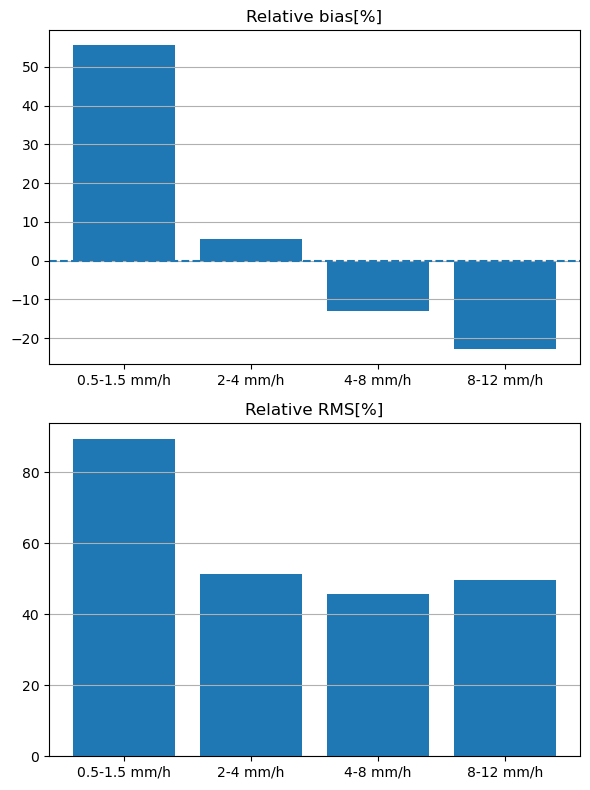

In [107]:
y_predLGBM=np.exp(test_model.predict([x1_test[:,:,:],x2_test[:,:,:]])[:,0])-1
#y_predLGBM=lgbReg.predict(xknn_test)
evalInt=[[0.5,1.5],[2,4],[4,8],[8,12]]
biasL=[]
rmsL=[]
for int1 in evalInt:
    a=np.nonzero((y_test>=int1[0]) & (y_test<int1[1]))
    bias=np.mean(y_predLGBM[a]-y_test[a])/np.mean(y_test[a])
    rms=np.sqrt(np.mean((y_predLGBM[a]-y_test[a])**2))/np.mean(y_test[a])
    biasL.append(bias)
    rmsL.append(rms)
plt.figure(figsize=(6,8))
plt.subplot(211)
cat=['0.5-1.5 mm/h','2-4 mm/h','4-8 mm/h','8-12 mm/h']
plt.bar(cat,np.array(biasL)*100)
#plt.axes().xaxis.set_visible(False)
plt.axhline(y=0,linestyle='--')
plt.grid(axis='y')

plt.title('Relative bias[%]')

plt.subplot(212)
plt.bar(cat,np.array(rmsL)*100)
plt.grid(axis='y')
plt.title('Relative RMS[%]')
plt.tight_layout()
plt.savefig('knnRegrPrecipScoresKuCONUS_KWAJ_Along.png')

print(biasL)
print(rmsL)

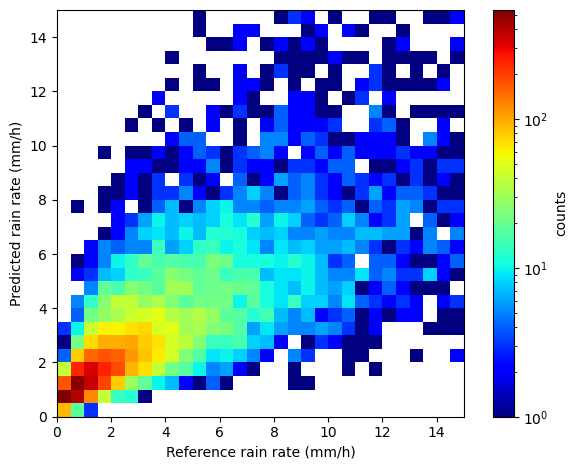

In [108]:
from matplotlib.colors import LogNorm
ax=plt.subplot(111)
h2=plt.hist2d(y_test,y_predLGBM[:],bins=np.arange(31)*0.5,norm=LogNorm(),cmap='jet')
ax.set_aspect('equal')
plt.xlabel('Reference rain rate (mm/h)')
plt.ylabel('Predicted rain rate (mm/h)')
c=plt.colorbar(label='counts')
plt.tight_layout()
plt.savefig('knnRegrPrecipKaW_CONUS_KWAJp_along.png')